In [1]:
%load_ext autoreload
%autoreload 2

import torch
import os
from resnet_module import ResNetModel
import torchmetrics.classification

from resnet_training import get_predictions, calculate_gender_bias, calculate_age_bias, calculate_hairiness_bias, calculate_skin_tone_bias

wandb: Currently logged in as: jacob314. Use `wandb login --relogin` to force relogin


In [2]:
simple_binary_debias = ["folm5wbd", "00riantl", "uiznsjjj", "30y8q6vf", "hi6ej7fl", "nl10rh1v", "xfh2oa3v", "i8zwc0lj", "062eb1li", "79uu4gax"]
simple_binary = ["kzozqfbw", "kdt4bf3x", "k7w8ngzr", "w572bz9r", "9e0j4szk", "3x8qz40u", "n3w92l9t", "ylc3xokv", "w2fevh40", "5guuqk3t"]

transfer_binary_debias = ["qoyvvmq3", "b4uy5hgy", "wagobkkx", "hs8iabty", "zknbfdl9", "7mh9iye3", "4vyhypbd", "fiwk3grk", "jv3m25z9", "ilhohkk0"]
transfer_binary = ["qmfpk3sj", "fstine2p", "8qrajii5", "fnyejif7", "yxar8zfy", "8mqtiupc", "jffizh6w", "rojiogbi", "gtc4c11b", "teurz8xp"]

multi_debias = ["l47c03l0", "1ldrdigg", "wx15lpd9", "miao7bd6", "nthtz4o2", "2bipf0jy", "jk959q53", "cgm7fzfj", "7jdsmgev", "uk0cgdr5"]
multi = ["nrdciusi", "q3knp3c5", "f47gne83", "ob5ydwmr", "043j12dt", "s60045hq", "4k9wi94n", "z59xq6lu", "8li362df", "48r7talu"] 

debiasing_runs = multi_debias
no_debiasing_runs = multi

In [3]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
num_classes=4
metric = torchmetrics.classification.MulticlassAccuracy(num_classes=num_classes, average='weighted')


results = {}

all_runs = debiasing_runs + no_debiasing_runs

for run in all_runs:
    print(f"Measuring biases for run {run}")
    results[run] = {}
    checkpoint_dir = f'./bias-skin-lesion-detection/{run}/checkpoints/'
    file_name = os.listdir(checkpoint_dir)[0]
    model_path = os.path.join(checkpoint_dir, file_name)
    
    model = ResNetModel.load_from_checkpoint(model_path, map_location=device)
    predictions, all_labels = get_predictions(model)

    gender_bias = calculate_gender_bias(predictions, all_labels, metric, num_classes=num_classes)
    results[run].update(gender_bias)
    age_bias = calculate_age_bias(predictions, all_labels, metric, num_classes=num_classes)
    results[run].update(age_bias)

    hairiness_bias = calculate_hairiness_bias(predictions, all_labels, metric, num_classes=num_classes)
    results[run].update(hairiness_bias)

    skin_tone_bias = calculate_skin_tone_bias(predictions, all_labels, metric, num_classes=num_classes)
    results[run].update(skin_tone_bias)
    
    class_labels = []
    for label in all_labels:
        class_labels.append(label[0].item())
    
    overall_accuracy = metric(predictions, torch.tensor(class_labels)).item()
    print(f"overall_acc: {overall_accuracy}")
    results[run].update({"overall_acc": overall_accuracy})


Measuring biases for run l47c03l0


/home/jschaefer/mitigating-bias-in-skin-lesion-detection-models/jsvenv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jschaefer/mitigating-bias-in-skin-lesion-detection-models/jsvenv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-PCIE-40GB') that has Tensor Cores. To properly utilize them, yo

Predicting: 0it [00:00, ?it/s]

Observed 248 labels out of 1390 to be unknown
male_acc: 0.6301145553588867
female_acc: 0.6082862615585327
bias: 0.00023823720511728652
Observed 0 ages out of 1390 to be unknown
upto30 has 153 samples
35to55 has 606 samples
60up has 631 samples
unknown has 0 samples
age_accuracies: {'upto30': 0.29411765933036804, '35to55': 0.7145214676856995, '60up': 0.49920761585235596}
age_bias: 0.04419355118952802
Observed 0 labels out of 1390 to be unknown
high_density_acc: 0.32692310214042664
low_density_acc: 0.579970121383667
hairiness_bias: 0.03201639697394443
Observed 430 skin tones out of 1390 to be 'Other'
Type I has 374 samples
Type II has 435 samples
Type III has 151 samples
Other has 430 samples
skin_accuracies: {'Type I': 0.43048128485679626, 'Type II': 0.36321839690208435, 'Type III': 0.4768211841583252}
skin_tone_bias: 0.0032628792726117815
overall_acc: 0.5705035924911499
Measuring biases for run 1ldrdigg


/home/jschaefer/mitigating-bias-in-skin-lesion-detection-models/jsvenv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jschaefer/mitigating-bias-in-skin-lesion-detection-models/jsvenv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-PCIE-40GB') that has Tensor Cores. To properly utilize them, yo

Predicting: 0it [00:00, ?it/s]

Observed 248 labels out of 1390 to be unknown
male_acc: 0.6219313144683838
female_acc: 0.6007533073425293
bias: 0.00022425399291137182
Observed 0 ages out of 1390 to be unknown
upto30 has 153 samples
35to55 has 606 samples
60up has 631 samples
unknown has 0 samples
age_accuracies: {'upto30': 0.3137255012989044, '35to55': 0.7095709443092346, '60up': 0.4881141185760498}
age_bias: 0.03935802170861624
Observed 0 labels out of 1390 to be unknown
high_density_acc: 0.36538460850715637
low_density_acc: 0.5732436180114746
hairiness_bias: 0.02160268391605813
Observed 430 skin tones out of 1390 to be 'Other'
Type I has 374 samples
Type II has 435 samples
Type III has 151 samples
Other has 430 samples
skin_accuracies: {'Type I': 0.40374332666397095, 'Type II': 0.36321839690208435, 'Type III': 0.45695364475250244}
skin_tone_bias: 0.0022099840954779757
overall_acc: 0.5654676556587219
Measuring biases for run wx15lpd9


/home/jschaefer/mitigating-bias-in-skin-lesion-detection-models/jsvenv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jschaefer/mitigating-bias-in-skin-lesion-detection-models/jsvenv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-PCIE-40GB') that has Tensor Cores. To properly utilize them, yo

Predicting: 0it [00:00, ?it/s]

Observed 248 labels out of 1390 to be unknown
male_acc: 0.5990179777145386
female_acc: 0.6007532477378845
bias: 1.5055810269615222e-06
Observed 0 ages out of 1390 to be unknown
upto30 has 153 samples
35to55 has 606 samples
60up has 631 samples
unknown has 0 samples
age_accuracies: {'upto30': 0.27450984716415405, '35to55': 0.7029702663421631, '60up': 0.4801901578903198}
age_bias: 0.04591894962407039
Observed 0 labels out of 1390 to be unknown
high_density_acc: 0.32692307233810425
low_density_acc: 0.5635277032852173
hairiness_bias: 0.02799087569280978
Observed 430 skin tones out of 1390 to be 'Other'
Type I has 374 samples
Type II has 435 samples
Type III has 151 samples
Other has 430 samples
skin_accuracies: {'Type I': 0.43048131465911865, 'Type II': 0.30344825983047485, 'Type III': 0.4768211841583252}
skin_tone_bias: 0.00805715856904854
overall_acc: 0.5546762347221375
Measuring biases for run miao7bd6


/home/jschaefer/mitigating-bias-in-skin-lesion-detection-models/jsvenv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jschaefer/mitigating-bias-in-skin-lesion-detection-models/jsvenv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-PCIE-40GB') that has Tensor Cores. To properly utilize them, yo

Predicting: 0it [00:00, ?it/s]

Observed 248 labels out of 1390 to be unknown
male_acc: 0.6235679388046265
female_acc: 0.6195856928825378
bias: 7.929141291995734e-06
Observed 0 ages out of 1390 to be unknown
upto30 has 153 samples
35to55 has 606 samples
60up has 631 samples
unknown has 0 samples
age_accuracies: {'upto30': 0.3529411852359772, '35to55': 0.7194719314575195, '60up': 0.4976227879524231}
age_bias: 0.034082432760710844
Observed 0 labels out of 1390 to be unknown
high_density_acc: 0.3461538553237915
low_density_acc: 0.5874439477920532
hairiness_bias: 0.029110454361671145
Observed 430 skin tones out of 1390 to be 'Other'
Type I has 374 samples
Type II has 435 samples
Type III has 151 samples
Other has 430 samples
skin_accuracies: {'Type I': 0.4358288645744324, 'Type II': 0.37011492252349854, 'Type III': 0.5231788158416748}
skin_tone_bias: 0.005896148600663527
overall_acc: 0.5784173011779785
Measuring biases for run nthtz4o2


/home/jschaefer/mitigating-bias-in-skin-lesion-detection-models/jsvenv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jschaefer/mitigating-bias-in-skin-lesion-detection-models/jsvenv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-PCIE-40GB') that has Tensor Cores. To properly utilize them, yo

Predicting: 0it [00:00, ?it/s]

Observed 248 labels out of 1390 to be unknown
male_acc: 0.6055646538734436
female_acc: 0.5969868302345276
bias: 3.67895291901732e-05
Observed 0 ages out of 1390 to be unknown
upto30 has 153 samples
35to55 has 606 samples
60up has 631 samples
unknown has 0 samples
age_accuracies: {'upto30': 0.2875817120075226, '35to55': 0.6996699571609497, '60up': 0.46909666061401367}
age_bias: 0.042654740573628246
Observed 0 labels out of 1390 to be unknown
high_density_acc: 0.38461539149284363
low_density_acc: 0.5560538172721863
hairiness_bias: 0.01469556691684959
Observed 430 skin tones out of 1390 to be 'Other'
Type I has 374 samples
Type II has 435 samples
Type III has 151 samples
Other has 430 samples
skin_accuracies: {'Type I': 0.39839568734169006, 'Type II': 0.3333333432674408, 'Type III': 0.41721856594085693}
skin_tone_bias: 0.0019373566596939302
overall_acc: 0.5496402978897095
Measuring biases for run 2bipf0jy


/home/jschaefer/mitigating-bias-in-skin-lesion-detection-models/jsvenv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jschaefer/mitigating-bias-in-skin-lesion-detection-models/jsvenv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-PCIE-40GB') that has Tensor Cores. To properly utilize them, yo

Predicting: 0it [00:00, ?it/s]

Observed 248 labels out of 1390 to be unknown
male_acc: 0.6104746460914612
female_acc: 0.5932202935218811
bias: 0.00014885634129768732
Observed 0 ages out of 1390 to be unknown
upto30 has 153 samples
35to55 has 606 samples
60up has 631 samples
unknown has 0 samples
age_accuracies: {'upto30': 0.2875817120075226, '35to55': 0.6996699571609497, '60up': 0.4833597242832184}
age_bias: 0.042489311455311984
Observed 0 labels out of 1390 to be unknown
high_density_acc: 0.42307692766189575
low_density_acc: 0.5612855553627014
hairiness_bias: 0.009550812385469953
Observed 430 skin tones out of 1390 to be 'Other'
Type I has 374 samples
Type II has 435 samples
Type III has 151 samples
Other has 430 samples
skin_accuracies: {'Type I': 0.3903743028640747, 'Type II': 0.34712645411491394, 'Type III': 0.4834437370300293}
skin_tone_bias: 0.004852449603126807
overall_acc: 0.5561150908470154
Measuring biases for run jk959q53


/home/jschaefer/mitigating-bias-in-skin-lesion-detection-models/jsvenv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jschaefer/mitigating-bias-in-skin-lesion-detection-models/jsvenv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-PCIE-40GB') that has Tensor Cores. To properly utilize them, yo

Predicting: 0it [00:00, ?it/s]

Observed 248 labels out of 1390 to be unknown
male_acc: 0.6301145553588867
female_acc: 0.6082862615585327
bias: 0.00023823720511728652
Observed 0 ages out of 1390 to be unknown
upto30 has 153 samples
35to55 has 606 samples
60up has 631 samples
unknown has 0 samples
age_accuracies: {'upto30': 0.33986929059028625, '35to55': 0.6897689700126648, '60up': 0.503961980342865}
age_bias: 0.030646738983378736
Observed 0 labels out of 1390 to be unknown
high_density_acc: 0.32692307233810425
low_density_acc: 0.5762332081794739
hairiness_bias: 0.03107777191662109
Observed 430 skin tones out of 1390 to be 'Other'
Type I has 374 samples
Type II has 435 samples
Type III has 151 samples
Other has 430 samples
skin_accuracies: {'Type I': 0.3903743028640747, 'Type II': 0.37471264600753784, 'Type III': 0.4768211841583252}
skin_tone_bias: 0.0030240840573808234
overall_acc: 0.5669064521789551
Measuring biases for run cgm7fzfj


/home/jschaefer/mitigating-bias-in-skin-lesion-detection-models/jsvenv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jschaefer/mitigating-bias-in-skin-lesion-detection-models/jsvenv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-PCIE-40GB') that has Tensor Cores. To properly utilize them, yo

Predicting: 0it [00:00, ?it/s]

Observed 248 labels out of 1390 to be unknown
male_acc: 0.628477931022644
female_acc: 0.6290019154548645
bias: 1.372798426046984e-07
Observed 0 ages out of 1390 to be unknown
upto30 has 153 samples
35to55 has 606 samples
60up has 631 samples
unknown has 0 samples
age_accuracies: {'upto30': 0.3529411852359772, '35to55': 0.7227723002433777, '60up': 0.503961980342865}
age_bias: 0.0345767150462164
Observed 0 labels out of 1390 to be unknown
high_density_acc: 0.3461538851261139
low_density_acc: 0.591928243637085
hairiness_bias: 0.03020251765073967
Observed 430 skin tones out of 1390 to be 'Other'
Type I has 374 samples
Type II has 435 samples
Type III has 151 samples
Other has 430 samples
skin_accuracies: {'Type I': 0.4331550598144531, 'Type II': 0.4045977294445038, 'Type III': 0.443708598613739}
skin_tone_bias: 0.00040942639770324973
overall_acc: 0.5827338099479675
Measuring biases for run 7jdsmgev


/home/jschaefer/mitigating-bias-in-skin-lesion-detection-models/jsvenv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jschaefer/mitigating-bias-in-skin-lesion-detection-models/jsvenv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-PCIE-40GB') that has Tensor Cores. To properly utilize them, yo

Predicting: 0it [00:00, ?it/s]

Observed 248 labels out of 1390 to be unknown
male_acc: 0.6121113300323486
female_acc: 0.6120527386665344
bias: 1.7164740739872286e-09
Observed 0 ages out of 1390 to be unknown
upto30 has 153 samples
35to55 has 606 samples
60up has 631 samples
unknown has 0 samples
age_accuracies: {'upto30': 0.3202614486217499, '35to55': 0.7029703259468079, '60up': 0.4896988868713379}
age_bias: 0.03677663949821852
Observed 0 labels out of 1390 to be unknown
high_density_acc: 0.38461539149284363
low_density_acc: 0.5710015296936035
hairiness_bias: 0.017369896256696382
Observed 430 skin tones out of 1390 to be 'Other'
Type I has 374 samples
Type II has 435 samples
Type III has 151 samples
Other has 430 samples
skin_accuracies: {'Type I': 0.3903743624687195, 'Type II': 0.3770114779472351, 'Type III': 0.47019869089126587}
skin_tone_bias: 0.002539057791186868
overall_acc: 0.564028799533844
Measuring biases for run uk0cgdr5


/home/jschaefer/mitigating-bias-in-skin-lesion-detection-models/jsvenv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jschaefer/mitigating-bias-in-skin-lesion-detection-models/jsvenv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-PCIE-40GB') that has Tensor Cores. To properly utilize them, yo

Predicting: 0it [00:00, ?it/s]

Observed 248 labels out of 1390 to be unknown
male_acc: 0.5859247446060181
female_acc: 0.5894538164138794
bias: 6.2271739125208114e-06
Observed 0 ages out of 1390 to be unknown
upto30 has 153 samples
35to55 has 606 samples
60up has 631 samples
unknown has 0 samples
age_accuracies: {'upto30': 0.29411765933036804, '35to55': 0.6798679828643799, '60up': 0.4754358232021332}
age_bias: 0.03724534942676557
Observed 0 labels out of 1390 to be unknown
high_density_acc: 0.38461539149284363
low_density_acc: 0.5508220791816711
hairiness_bias: 0.013812331516245724
Observed 430 skin tones out of 1390 to be 'Other'
Type I has 374 samples
Type II has 435 samples
Type III has 151 samples
Other has 430 samples
skin_accuracies: {'Type I': 0.3903743028640747, 'Type II': 0.3264367878437042, 'Type III': 0.49668872356414795}
skin_tone_bias: 0.007396080582055061
overall_acc: 0.5446043610572815
Measuring biases for run nrdciusi


/home/jschaefer/mitigating-bias-in-skin-lesion-detection-models/jsvenv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jschaefer/mitigating-bias-in-skin-lesion-detection-models/jsvenv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-PCIE-40GB') that has Tensor Cores. To properly utilize them, yo

Predicting: 0it [00:00, ?it/s]

Observed 248 labels out of 1390 to be unknown
male_acc: 0.6366612911224365
female_acc: 0.6233521699905396
bias: 8.856635265175328e-05
Observed 0 ages out of 1390 to be unknown
upto30 has 153 samples
35to55 has 606 samples
60up has 631 samples
unknown has 0 samples
age_accuracies: {'upto30': 0.2679738700389862, '35to55': 0.7194719314575195, '60up': 0.49920758605003357}
age_bias: 0.05097265212379328
Observed 0 labels out of 1390 to be unknown
high_density_acc: 0.36538460850715637
low_density_acc: 0.5777279138565063
hairiness_bias: 0.02254483966334364
Observed 430 skin tones out of 1390 to be 'Other'
Type I has 374 samples
Type II has 435 samples
Type III has 151 samples
Other has 430 samples
skin_accuracies: {'Type I': 0.42513367533683777, 'Type II': 0.36321836709976196, 'Type III': 0.4768211841583252}
skin_tone_bias: 0.003235117334317472
overall_acc: 0.5697841644287109
Measuring biases for run q3knp3c5


/home/jschaefer/mitigating-bias-in-skin-lesion-detection-models/jsvenv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jschaefer/mitigating-bias-in-skin-lesion-detection-models/jsvenv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-PCIE-40GB') that has Tensor Cores. To properly utilize them, yo

Predicting: 0it [00:00, ?it/s]

Observed 248 labels out of 1390 to be unknown
male_acc: 0.6055646538734436
female_acc: 0.6120526790618896
bias: 2.104723542295517e-05
Observed 0 ages out of 1390 to be unknown
upto30 has 153 samples
35to55 has 606 samples
60up has 631 samples
unknown has 0 samples
age_accuracies: {'upto30': 0.26143792271614075, '35to55': 0.6963696479797363, '60up': 0.48494452238082886}
age_bias: 0.047303564911492124
Observed 0 labels out of 1390 to be unknown
high_density_acc: 0.32692310214042664
low_density_acc: 0.5612854361534119
hairiness_bias: 0.027462851802007027
Observed 430 skin tones out of 1390 to be 'Other'
Type I has 374 samples
Type II has 435 samples
Type III has 151 samples
Other has 430 samples
skin_accuracies: {'Type I': 0.427807480096817, 'Type II': 0.3287356495857239, 'Type III': 0.42384105920791626}
skin_tone_bias: 0.003145999839148613
overall_acc: 0.5525179505348206
Measuring biases for run f47gne83


/home/jschaefer/mitigating-bias-in-skin-lesion-detection-models/jsvenv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jschaefer/mitigating-bias-in-skin-lesion-detection-models/jsvenv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-PCIE-40GB') that has Tensor Cores. To properly utilize them, yo

Predicting: 0it [00:00, ?it/s]

Observed 248 labels out of 1390 to be unknown
male_acc: 0.6235679388046265
female_acc: 0.6290018558502197
bias: 1.4763727229194501e-05
Observed 0 ages out of 1390 to be unknown
upto30 has 153 samples
35to55 has 606 samples
60up has 631 samples
unknown has 0 samples
age_accuracies: {'upto30': 0.3006536066532135, '35to55': 0.7194719314575195, '60up': 0.49286848306655884}
age_bias: 0.04395074512152627
Observed 0 labels out of 1390 to be unknown
high_density_acc: 0.3461538553237915
low_density_acc: 0.5792227387428284
hairiness_bias: 0.0271605522090983
Observed 430 skin tones out of 1390 to be 'Other'
Type I has 374 samples
Type II has 435 samples
Type III has 151 samples
Other has 430 samples
skin_accuracies: {'Type I': 0.44919782876968384, 'Type II': 0.34712645411491394, 'Type III': 0.4437086284160614}
skin_tone_bias: 0.0032961355395289735
overall_acc: 0.5705036520957947
Measuring biases for run ob5ydwmr


/home/jschaefer/mitigating-bias-in-skin-lesion-detection-models/jsvenv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jschaefer/mitigating-bias-in-skin-lesion-detection-models/jsvenv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-PCIE-40GB') that has Tensor Cores. To properly utilize them, yo

Predicting: 0it [00:00, ?it/s]

Observed 248 labels out of 1390 to be unknown
male_acc: 0.6235679388046265
female_acc: 0.625235378742218
bias: 1.3901779727376606e-06
Observed 0 ages out of 1390 to be unknown
upto30 has 153 samples
35to55 has 606 samples
60up has 631 samples
unknown has 0 samples
age_accuracies: {'upto30': 0.30718955397605896, '35to55': 0.7095709443092346, '60up': 0.496038019657135}
age_bias: 0.04052847269783921
Observed 0 labels out of 1390 to be unknown
high_density_acc: 0.36538463830947876
low_density_acc: 0.5762331485748291
hairiness_bias: 0.022228547140558774
Observed 430 skin tones out of 1390 to be 'Other'
Type I has 374 samples
Type II has 435 samples
Type III has 151 samples
Other has 430 samples
skin_accuracies: {'Type I': 0.44385024905204773, 'Type II': 0.33563217520713806, 'Type III': 0.4768211841583252}
skin_tone_bias: 0.005455428386183847
overall_acc: 0.568345308303833
Measuring biases for run 043j12dt


/home/jschaefer/mitigating-bias-in-skin-lesion-detection-models/jsvenv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jschaefer/mitigating-bias-in-skin-lesion-detection-models/jsvenv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-PCIE-40GB') that has Tensor Cores. To properly utilize them, yo

Predicting: 0it [00:00, ?it/s]

Observed 248 labels out of 1390 to be unknown
male_acc: 0.6235679388046265
female_acc: 0.6346515417098999
bias: 6.142312668089289e-05
Observed 0 ages out of 1390 to be unknown
upto30 has 153 samples
35to55 has 606 samples
60up has 631 samples
unknown has 0 samples
age_accuracies: {'upto30': 0.32679739594459534, '35to55': 0.7161716222763062, '60up': 0.4817749559879303}
age_bias: 0.03842868823591802
Observed 0 labels out of 1390 to be unknown
high_density_acc: 0.384615421295166
low_density_acc: 0.5739910006523132
hairiness_bias: 0.01793155502842758
Observed 430 skin tones out of 1390 to be 'Other'
Type I has 374 samples
Type II has 435 samples
Type III has 151 samples
Other has 430 samples
skin_accuracies: {'Type I': 0.43048128485679626, 'Type II': 0.3563218414783478, 'Type III': 0.4105960428714752}
skin_tone_bias: 0.0014734558046463064
overall_acc: 0.5669064521789551
Measuring biases for run s60045hq


/home/jschaefer/mitigating-bias-in-skin-lesion-detection-models/jsvenv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jschaefer/mitigating-bias-in-skin-lesion-detection-models/jsvenv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-PCIE-40GB') that has Tensor Cores. To properly utilize them, yo

Predicting: 0it [00:00, ?it/s]

Observed 248 labels out of 1390 to be unknown
male_acc: 0.6301145553588867
female_acc: 0.6365348696708679
bias: 2.0610217932315322e-05
Observed 0 ages out of 1390 to be unknown
upto30 has 153 samples
35to55 has 606 samples
60up has 631 samples
unknown has 0 samples
age_accuracies: {'upto30': 0.3137255012989044, '35to55': 0.7310231328010559, '60up': 0.48652929067611694}
age_bias: 0.04396261695290734
Observed 0 labels out of 1390 to be unknown
high_density_acc: 0.36538463830947876
low_density_acc: 0.5822123289108276
hairiness_bias: 0.023507123705757138
Observed 430 skin tones out of 1390 to be 'Other'
Type I has 374 samples
Type II has 435 samples
Type III has 151 samples
Other has 430 samples
skin_accuracies: {'Type I': 0.4411764442920685, 'Type II': 0.365517258644104, 'Type III': 0.4370861053466797}
skin_tone_bias: 0.0018105238439896827
overall_acc: 0.5741007328033447
Measuring biases for run 4k9wi94n


/home/jschaefer/mitigating-bias-in-skin-lesion-detection-models/jsvenv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jschaefer/mitigating-bias-in-skin-lesion-detection-models/jsvenv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-PCIE-40GB') that has Tensor Cores. To properly utilize them, yo

Predicting: 0it [00:00, ?it/s]

Observed 248 labels out of 1390 to be unknown
male_acc: 0.6301145553588867
female_acc: 0.6158191561698914
bias: 0.00010217921898636462
Observed 0 ages out of 1390 to be unknown
upto30 has 153 samples
35to55 has 606 samples
60up has 631 samples
unknown has 0 samples
age_accuracies: {'upto30': 0.2810457646846771, '35to55': 0.7079207897186279, '60up': 0.49920761585235596}
age_bias: 0.045563011541329544
Observed 0 labels out of 1390 to be unknown
high_density_acc: 0.4423077404499054
low_density_acc: 0.5710014700889587
hairiness_bias: 0.008281038024204879
Observed 430 skin tones out of 1390 to be 'Other'
Type I has 374 samples
Type II has 435 samples
Type III has 151 samples
Other has 430 samples
skin_accuracies: {'Type I': 0.44117647409439087, 'Type II': 0.33563220500946045, 'Type III': 0.45695364475250244}
skin_tone_bias: 0.004351233931995324
overall_acc: 0.5661870241165161
Measuring biases for run z59xq6lu


/home/jschaefer/mitigating-bias-in-skin-lesion-detection-models/jsvenv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jschaefer/mitigating-bias-in-skin-lesion-detection-models/jsvenv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-PCIE-40GB') that has Tensor Cores. To properly utilize them, yo

Predicting: 0it [00:00, ?it/s]

Observed 248 labels out of 1390 to be unknown
male_acc: 0.6202945709228516
female_acc: 0.6177024245262146
bias: 3.3596114707989955e-06
Observed 0 ages out of 1390 to be unknown
upto30 has 153 samples
35to55 has 606 samples
60up has 631 samples
unknown has 0 samples
age_accuracies: {'upto30': 0.3006536066532135, '35to55': 0.6963696479797363, '60up': 0.49445322155952454}
age_bias: 0.039153286559879596
Observed 0 labels out of 1390 to be unknown
high_density_acc: 0.32692310214042664
low_density_acc: 0.5702541470527649
hairiness_bias: 0.02960499870906519
Observed 430 skin tones out of 1390 to be 'Other'
Type I has 374 samples
Type II has 435 samples
Type III has 151 samples
Other has 430 samples
skin_accuracies: {'Type I': 0.4438502788543701, 'Type II': 0.33103448152542114, 'Type III': 0.45695364475250244}
skin_tone_bias: 0.0047924563321058615
overall_acc: 0.5611510872840881
Measuring biases for run 8li362df


/home/jschaefer/mitigating-bias-in-skin-lesion-detection-models/jsvenv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jschaefer/mitigating-bias-in-skin-lesion-detection-models/jsvenv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-PCIE-40GB') that has Tensor Cores. To properly utilize them, yo

Predicting: 0it [00:00, ?it/s]

Observed 248 labels out of 1390 to be unknown
male_acc: 0.6333878636360168
female_acc: 0.6365348696708679
bias: 4.95182349169454e-06
Observed 0 ages out of 1390 to be unknown
upto30 has 153 samples
35to55 has 606 samples
60up has 631 samples
unknown has 0 samples
age_accuracies: {'upto30': 0.32679739594459534, '35to55': 0.7145214676856995, '60up': 0.5134706497192383}
age_bias: 0.037599715147882705
Observed 0 labels out of 1390 to be unknown
high_density_acc: 0.3461538553237915
low_density_acc: 0.5896860957145691
hairiness_bias: 0.02965397605487574
Observed 430 skin tones out of 1390 to be 'Other'
Type I has 374 samples
Type II has 435 samples
Type III has 151 samples
Other has 430 samples
skin_accuracies: {'Type I': 0.4625668525695801, 'Type II': 0.3816092014312744, 'Type III': 0.42384105920791626}
skin_tone_bias: 0.001639559693431399
overall_acc: 0.5805755853652954
Measuring biases for run 48r7talu


/home/jschaefer/mitigating-bias-in-skin-lesion-detection-models/jsvenv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jschaefer/mitigating-bias-in-skin-lesion-detection-models/jsvenv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-PCIE-40GB') that has Tensor Cores. To properly utilize them, yo

Predicting: 0it [00:00, ?it/s]

Observed 248 labels out of 1390 to be unknown
male_acc: 0.6235678791999817
female_acc: 0.6233521699905396
bias: 2.3265231519076224e-08
Observed 0 ages out of 1390 to be unknown
upto30 has 153 samples
35to55 has 606 samples
60up has 631 samples
unknown has 0 samples
age_accuracies: {'upto30': 0.3006536066532135, '35to55': 0.7128713130950928, '60up': 0.4944532513618469}
age_bias: 0.04253136491411732
Observed 0 labels out of 1390 to be unknown
high_density_acc: 0.3461538553237915
low_density_acc: 0.5769805908203125
hairiness_bias: 0.026640490909990433
Observed 430 skin tones out of 1390 to be 'Other'
Type I has 374 samples
Type II has 435 samples
Type III has 151 samples
Other has 430 samples
skin_accuracies: {'Type I': 0.44652408361434937, 'Type II': 0.3379310071468353, 'Type III': 0.4768211841583252}
skin_tone_bias: 0.005333475304722353
overall_acc: 0.568345308303833


In [4]:
print(results)

{'l47c03l0': {'male_acc': 0.6301145553588867, 'female_acc': 0.6082862615585327, 'gender_bias': 0.00023823720511728652, 'age_accuracies': {'upto30': 0.29411765933036804, '35to55': 0.7145214676856995, '60up': 0.49920761585235596}, 'age_bias': 0.04419355118952802, 'high_density_acc': 0.32692310214042664, 'low_density_acc': 0.579970121383667, 'hairiness_bias': 0.03201639697394443, 'skin_accuracies': {'Type I': 0.43048128485679626, 'Type II': 0.36321839690208435, 'Type III': 0.4768211841583252}, 'skin_tone_bias': 0.0032628792726117815, 'overall_acc': 0.5705035924911499}, '1ldrdigg': {'male_acc': 0.6219313144683838, 'female_acc': 0.6007533073425293, 'gender_bias': 0.00022425399291137182, 'age_accuracies': {'upto30': 0.3137255012989044, '35to55': 0.7095709443092346, '60up': 0.4881141185760498}, 'age_bias': 0.03935802170861624, 'high_density_acc': 0.36538460850715637, 'low_density_acc': 0.5732436180114746, 'hairiness_bias': 0.02160268391605813, 'skin_accuracies': {'Type I': 0.40374332666397095

In [8]:
simple_binary_results = results_simple_binary = {'folm5wbd': {'male_acc': 0.790554404258728, 'female_acc': 0.827051043510437, 'gender_bias': 0.0006660023383346925, 'age_accuracies': {'upto30': 0.625, '35to55': 0.8709090948104858, '60up': 0.6891191601753235}, 'age_bias': 0.01627168832445965, 'high_density_acc': 0.64000004529953, 'low_density_acc': 0.7796116471290588, 'hairiness_bias': 0.009745699682703446, 'skin_accuracies': {'Type I': 0.7032967209815979, 'Type II': 0.5562701225280762, 'Type III': 0.7272727489471436}, 'skin_tone_bias': 0.008572261468672812, 'overall_acc': 0.7731}, '00riantl': {'male_acc': 0.7967145442962646, 'female_acc': 0.8625277280807495, 'gender_bias': 0.0021656875799251907, 'age_accuracies': {'upto30': 0.6736111044883728, '35to55': 0.8781818151473999, '60up': 0.7098445296287537}, 'age_bias': 0.011916579742121533, 'high_density_acc': 0.6800000071525574, 'low_density_acc': 0.7961164712905884, 'hairiness_bias': 0.00674151662195932, 'skin_accuracies': {'Type I': 0.7875458002090454, 'Type II': 0.5530546307563782, 'Type III': 0.6931818723678589}, 'skin_tone_bias': 0.013921050545089741, 'overall_acc': 0.7907}, 'uiznsjjj': {'male_acc': 0.8172484636306763, 'female_acc': 0.8580931425094604, 'gender_bias': 0.0008341438963554992, 'age_accuracies': {'upto30': 0.7083333730697632, '35to55': 0.8836363554000854, '60up': 0.7305699586868286}, 'age_bias': 0.009109153859431748, 'high_density_acc': 0.6800000071525574, 'low_density_acc': 0.8116504549980164, 'hairiness_bias': 0.008665920208954958, 'skin_accuracies': {'Type I': 0.732600748538971, 'Type II': 0.6430867910385132, 'Type III': 0.7159091234207153}, 'skin_tone_bias': 0.002265741838344345, 'overall_acc': 0.8056}, '30y8q6vf': {'male_acc': 0.804928183555603, 'female_acc': 0.8514412641525269, 'gender_bias': 0.001081733333307966, 'age_accuracies': {'upto30': 0.6875, '35to55': 0.8727272748947144, '60up': 0.7227979302406311}, 'age_bias': 0.009672315938766237, 'high_density_acc': 0.7400000095367432, 'low_density_acc': 0.7970874309539795, 'hairiness_bias': 0.0016294868420345665, 'skin_accuracies': {'Type I': 0.7545787692070007, 'Type II': 0.5916398167610168, 'Type III': 0.6931817531585693}, 'skin_tone_bias': 0.006771576775201756, 'overall_acc': 0.7944}, 'hi6ej7fl': {'male_acc': 0.7987679243087769, 'female_acc': 0.8558758497238159, 'gender_bias': 0.0016306575726048322, 'age_accuracies': {'upto30': 0.6875, '35to55': 0.8672727346420288, '60up': 0.7098445892333984}, 'age_bias': 0.009600189625913913, 'high_density_acc': 0.6200000047683716, 'low_density_acc': 0.7951456308364868, 'hairiness_bias': 0.015337995165396023, 'skin_accuracies': {'Type I': 0.7142857313156128, 'Type II': 0.6012861728668213, 'Type III': 0.6931818723678589}, 'skin_tone_bias': 0.003609848776482257, 'overall_acc': 0.7870}, 'nl10rh1v': {'male_acc': 0.7885010242462158, 'female_acc': 0.8447893857955933, 'gender_bias': 0.0015841898229567164, 'age_accuracies': {'upto30': 0.6666666865348816, '35to55': 0.8672727346420288, '60up': 0.7020725011825562}, 'age_bias': 0.011464579230516136, 'high_density_acc': 0.699999988079071, 'low_density_acc': 0.7854369282722473, 'hairiness_bias': 0.0036497353747861894, 'skin_accuracies': {'Type I': 0.7252747416496277, 'Type II': 0.5723472833633423, 'Type III': 0.6818181872367859}, 'skin_tone_bias': 0.0062098597357014285, 'overall_acc': 0.7815}, 'xfh2oa3v': {'male_acc': 0.7823408842086792, 'female_acc': 0.8492239713668823, 'gender_bias': 0.002236673673905898, 'age_accuracies': {'upto30': 0.625, '35to55': 0.8690909147262573, '60up': 0.7072538733482361}, 'age_bias': 0.015422883715780008, 'high_density_acc': 0.6800000071525574, 'low_density_acc': 0.7834951281547546, 'hairiness_bias': 0.005355620035629727, 'skin_accuracies': {'Type I': 0.7106227278709412, 'Type II': 0.5755627155303955, 'Type III': 0.7045454978942871}, 'skin_tone_bias': 0.005819116300658085, 'overall_acc': 0.7787}, 'i8zwc0lj': {'male_acc': 0.8069815635681152, 'female_acc': 0.827051043510437, 'gender_bias': 0.00020139201257762807, 'age_accuracies': {'upto30': 0.6527777910232544, '35to55': 0.8563635945320129, '60up': 0.7227979302406311}, 'age_bias': 0.010698297660654296, 'high_density_acc': 0.64000004529953, 'low_density_acc': 0.7883495092391968, 'hairiness_bias': 0.011003781725593242, 'skin_accuracies': {'Type I': 0.7399267554283142, 'Type II': 0.5627009868621826, 'Type III': 0.7045454978942871}, 'skin_tone_bias': 0.008796778623080334, 'overall_acc': 0.7815}, '062eb1li': {'male_acc': 0.7885010242462158, 'female_acc': 0.8381375074386597, 'gender_bias': 0.0012318902318568803, 'age_accuracies': {'upto30': 0.6458333730697632, '35to55': 0.85999995470047, '60up': 0.6994818449020386}, 'age_bias': 0.012418591131763653, 'high_density_acc': 0.6600000262260437, 'low_density_acc': 0.7796115875244141, 'hairiness_bias': 0.007153462798116905, 'skin_accuracies': {'Type I': 0.7142857313156128, 'Type II': 0.5659164190292358, 'Type III': 0.6931818723678589}, 'skin_tone_bias': 0.006442553550717396, 'overall_acc': 0.7741}, '79uu4gax': {'male_acc': 0.802874743938446, 'female_acc': 0.8669623136520386, 'gender_bias': 0.002053608295897291, 'age_accuracies': {'upto30': 0.6736111044883728, '35to55': 0.8836363554000854, '60up': 0.7279792428016663}, 'age_bias': 0.011882606197776369, 'high_density_acc': 0.7200000286102295, 'low_density_acc': 0.8038834929466248, 'hairiness_bias': 0.003518217794537648, 'skin_accuracies': {'Type I': 0.7435897588729858, 'Type II': 0.6205787658691406, 'Type III': 0.7159091234207153}, 'skin_tone_bias': 0.004164299841624104, 'overall_acc': 0.8000}, 'kzozqfbw': {'male_acc': 0.7659137845039368, 'female_acc': 0.7849224209785461, 'gender_bias': 0.00018066413031192496, 'age_accuracies': {'upto30': 0.5208333730697632, '35to55': 0.8290908932685852, '60up': 0.6709845066070557}, 'age_bias': 0.023760948527471015, 'high_density_acc': 0.699999988079071, 'low_density_acc': 0.7330096960067749, 'hairiness_bias': 0.0005448204087361574, 'skin_accuracies': {'Type I': 0.6483516693115234, 'Type II': 0.47909969091415405, 'Type III': 0.6477272510528564}, 'skin_tone_bias': 0.009513646021319508, 'overall_acc': 0.7315}, 'kdt4bf3x': {'male_acc': 0.7618069648742676, 'female_acc': 0.7849224209785461, 'gender_bias': 0.0002671621554544146, 'age_accuracies': {'upto30': 0.5555555820465088, '35to55': 0.8181818127632141, '60up': 0.6683937311172485}, 'age_bias': 0.01735690905822551, 'high_density_acc': 0.6800000071525574, 'low_density_acc': 0.7320387959480286, 'hairiness_bias': 0.001354017769649829, 'skin_accuracies': {'Type I': 0.6520146727561951, 'Type II': 0.47588425874710083, 'Type III': 0.6363636255264282}, 'skin_tone_bias': 0.009503417530049537, 'overall_acc': 0.7296}, 'k7w8ngzr': {'male_acc': 0.7515400052070618, 'female_acc': 0.7694013714790344, 'gender_bias': 0.0001595142025507812, 'age_accuracies': {'upto30': 0.4930555820465088, '35to55': 0.8072726726531982, '60up': 0.6424870491027832}, 'age_bias': 0.024702740850803668, 'high_density_acc': 0.5799999833106995, 'low_density_acc': 0.7126213312149048, 'hairiness_bias': 0.008794210959964133, 'skin_accuracies': {'Type I': 0.6556776762008667, 'Type II': 0.41800642013549805, 'Type III': 0.5568181276321411}, 'skin_tone_bias': 0.014254921073505974, 'overall_acc': 0.7065}, 'w572bz9r': {'male_acc': 0.755646824836731, 'female_acc': 0.809312641620636, 'gender_bias': 0.0014400099455418314, 'age_accuracies': {'upto30': 0.569444477558136, '35to55': 0.8236363530158997, '60up': 0.6632124185562134}, 'age_bias': 0.01652362917587998, 'high_density_acc': 0.7200000286102295, 'low_density_acc': 0.7330096960067749, 'hairiness_bias': 8.462572288436832e-05, 'skin_accuracies': {'Type I': 0.6336996555328369, 'Type II': 0.49196141958236694, 'Type III': 0.6590909361839294}, 'skin_tone_bias': 0.008111119997154267, 'overall_acc': 0.7324}, '9e0j4szk': {'male_acc': 0.7310061454772949, 'female_acc': 0.776053249835968, 'gender_bias': 0.0010146208055505923, 'age_accuracies': {'upto30': 0.4861111342906952, '35to55': 0.8054544925689697, '60up': 0.6269429922103882}, 'age_bias': 0.025613358073638477, 'high_density_acc': 0.6200000643730164, 'low_density_acc': 0.7029126286506653, 'hairiness_bias': 0.0034372466575476324, 'skin_accuracies': {'Type I': 0.5970696210861206, 'Type II': 0.4437299072742462, 'Type III': 0.5909091234207153}, 'skin_tone_bias': 0.0075354568714803465, 'overall_acc': 0.6991}, '3x8qz40u': {'male_acc': 0.7207392454147339, 'female_acc': 0.7804878354072571, 'gender_bias': 0.0017849470030473213, 'age_accuracies': {'upto30': 0.4583333432674408, '35to55': 0.8090909123420715, '60up': 0.6424870491027832}, 'age_bias': 0.03078338448038161, 'high_density_acc': 0.6399999856948853, 'low_density_acc': 0.7058252096176147, 'hairiness_bias': 0.0021664800522387395, 'skin_accuracies': {'Type I': 0.622710645198822, 'Type II': 0.42122188210487366, 'Type III': 0.5909090638160706}, 'skin_tone_bias': 0.011733800311443629, 'overall_acc': 0.7028}, 'n3w92l9t': {'male_acc': 0.7392196655273438, 'female_acc': 0.7893570065498352, 'gender_bias': 0.0012568764824028023, 'age_accuracies': {'upto30': 0.5138888955116272, '35to55': 0.8090909123420715, '60up': 0.6295336484909058}, 'age_bias': 0.022126458439019576, 'high_density_acc': 0.5400000214576721, 'low_density_acc': 0.7135922312736511, 'hairiness_bias': 0.015067127654397439, 'skin_accuracies': {'Type I': 0.6043955683708191, 'Type II': 0.4533762037754059, 'Type III': 0.5681818127632141}, 'skin_tone_bias': 0.0062164354055118665, 'overall_acc': 0.7056}, 'ylc3xokv': {'male_acc': 0.7577002048492432, 'female_acc': 0.7871397137641907, 'gender_bias': 0.00043334234257663695, 'age_accuracies': {'upto30': 0.5625, '35to55': 0.8127272725105286, '60up': 0.6735751628875732}, 'age_bias': 0.015719114888513037, 'high_density_acc': 0.6200000643730164, 'low_density_acc': 0.7349514961242676, 'hairiness_bias': 0.006606915830831284, 'skin_accuracies': {'Type I': 0.6776556968688965, 'Type II': 0.4565916657447815, 'Type III': 0.625}, 'skin_tone_bias': 0.0133338825527017, 'overall_acc': 0.7296}, 'w2fevh40': {'male_acc': 0.755646824836731, 'female_acc': 0.776053249835968, 'gender_bias': 0.00020821109062474363, 'age_accuracies': {'upto30': 0.5138888955116272, '35to55': 0.8109090924263, '60up': 0.6450777053833008}, 'age_bias': 0.022155258356563696, 'high_density_acc': 0.6800000071525574, 'low_density_acc': 0.7135922312736511, 'hairiness_bias': 0.0005642187607008964, 'skin_accuracies': {'Type I': 0.6153846383094788, 'Type II': 0.45016077160835266, 'Type III': 0.6363636255264282}, 'skin_tone_bias': 0.010401757806592768, 'overall_acc': 0.7120}, '5guuqk3t': {'male_acc': 0.7433264851570129, 'female_acc': 0.7893570065498352, 'gender_bias': 0.0010594044498475341, 'age_accuracies': {'upto30': 0.4791666865348816, '35to55': 0.8218181729316711, '60up': 0.665803074836731}, 'age_bias': 0.029430648900310292, 'high_density_acc': 0.64000004529953, 'low_density_acc': 0.724271833896637, 'hairiness_bias': 0.003550867176677741, 'skin_accuracies': {'Type I': 0.6739926934242249, 'Type II': 0.4437299072742462, 'Type III': 0.5795454382896423}, 'skin_tone_bias': 0.013397848858833624, 'overall_acc': 0.7204}}

transfer_results = {'qoyvvmq3': {'male_acc': 0.8254619836807251, 'female_acc': 0.8780487775802612, 'gender_bias': 0.0013826854463161453, 'age_accuracies': {'upto30': 0.756944477558136, '35to55': 0.892727255821228, '60up': 0.803108811378479}, 'age_bias': 0.004766595695709697, 'high_density_acc': 0.8200000524520874, 'low_density_acc': 0.8436893224716187, 'hairiness_bias': 0.00028059075702913105, 'skin_accuracies': {'Type I': 0.8021978139877319, 'Type II': 0.6945337653160095, 'Type III': 0.7727272510528564}, 'skin_tone_bias': 0.003095713777960659, 'overall_acc': 0.8426}, 'b4uy5hgy': {'male_acc': 0.8316221833229065, 'female_acc': 0.8403548002243042, 'gender_bias': 3.812929897328843e-05, 'age_accuracies': {'upto30': 0.6875, '35to55': 0.8654545545578003, '60up': 0.8290155529975891}, 'age_bias': 0.008837046010463942, 'high_density_acc': 0.8999999761581421, 'low_density_acc': 0.8252427577972412, 'hairiness_bias': 0.0027943208485297077, 'skin_accuracies': {'Type I': 0.8278388381004333, 'Type II': 0.6270096302032471, 'Type III': 0.7727272510528564}, 'skin_tone_bias': 0.010767213799597405, 'overall_acc': 0.8287}, 'wagobkkx': {'male_acc': 0.8090348839759827, 'female_acc': 0.8713968992233276, 'gender_bias': 0.0019445104728550433, 'age_accuracies': {'upto30': 0.743055522441864, '35to55': 0.8727272748947144, '60up': 0.7927461266517639}, 'age_bias': 0.004280150600866506, 'high_density_acc': 0.8799999952316284, 'low_density_acc': 0.8242717981338501, 'hairiness_bias': 0.001552815975884414, 'skin_accuracies': {'Type I': 0.8131868243217468, 'Type II': 0.6334404945373535, 'Type III': 0.75}, 'skin_tone_bias': 0.008314572692087316, 'overall_acc': 0.8269}, 'hs8iabty': {'male_acc': 0.8377823233604431, 'female_acc': 0.8713968992233276, 'gender_bias': 0.0005649698552208093, 'age_accuracies': {'upto30': 0.7361111044883728, '35to55': 0.889090895652771, '60up': 0.834196925163269}, 'age_bias': 0.006006165453045516, 'high_density_acc': 0.8999999761581421, 'low_density_acc': 0.8466019630432129, 'hairiness_bias': 0.0014256739023110754, 'skin_accuracies': {'Type I': 0.8424908518791199, 'Type II': 0.6913183331489563, 'Type III': 0.75}, 'skin_tone_bias': 0.005808537687493971, 'overall_acc': 0.8491}, 'zknbfdl9': {'male_acc': 0.8357289433479309, 'female_acc': 0.8780487775802612, 'gender_bias': 0.0008954841847259587, 'age_accuracies': {'upto30': 0.756944477558136, '35to55': 0.8872727155685425, '60up': 0.8238341808319092}, 'age_bias': 0.004247354952746936, 'high_density_acc': 0.8999999761581421, 'low_density_acc': 0.8446601629257202, 'hairiness_bias': 0.0015312474642996676, 'skin_accuracies': {'Type I': 0.8241758346557617, 'Type II': 0.6848874688148499, 'Type III': 0.7954545021057129}, 'skin_tone_bias': 0.005408538775470835, 'overall_acc': 0.8472}, '7mh9iye3': {'male_acc': 0.8377823829650879, 'female_acc': 0.8669623136520386, 'gender_bias': 0.0004257341774476231, 'age_accuracies': {'upto30': 0.7291666269302368, '35to55': 0.885454535484314, '60up': 0.8367875814437866}, 'age_bias': 0.006396108771032989, 'high_density_acc': 0.8600000143051147, 'low_density_acc': 0.8466019630432129, 'hairiness_bias': 8.975388880827495e-05, 'skin_accuracies': {'Type I': 0.8095238208770752, 'Type II': 0.6945337653160095, 'Type III': 0.8068181276321411}, 'skin_tone_bias': 0.004306301945768827, 'overall_acc': 0.8472}, '4vyhypbd': {'male_acc': 0.8172484636306763, 'female_acc': 0.8558758497238159, 'gender_bias': 0.0007460374781942392, 'age_accuracies': {'upto30': 0.6875, '35to55': 0.8672727346420288, '60up': 0.8082901239395142}, 'age_bias': 0.008397906421213483, 'high_density_acc': 0.8200000524520874, 'low_density_acc': 0.822330117225647, 'hairiness_bias': 2.714600924491606e-06, 'skin_accuracies': {'Type I': 0.7802197933197021, 'Type II': 0.6430867910385132, 'Type III': 0.7613636255264282}, 'skin_tone_bias': 0.0055250708258303876, 'overall_acc': 0.8222}, 'fiwk3grk': {'male_acc': 0.8090348839759827, 'female_acc': 0.8492239713668823, 'gender_bias': 0.000807581372656685, 'age_accuracies': {'upto30': 0.6597222089767456, '35to55': 0.85999995470047, '60up': 0.8056994676589966}, 'age_bias': 0.010728179729583806, 'high_density_acc': 0.8600000143051147, 'low_density_acc': 0.8116505146026611, 'hairiness_bias': 0.001168837060738781, 'skin_accuracies': {'Type I': 0.7802197933197021, 'Type II': 0.6334404945373535, 'Type III': 0.7272727489471436}, 'skin_tone_bias': 0.005525340671075203, 'overall_acc': 0.8139}, 'jv3m25z9': {'male_acc': 0.8254620432853699, 'female_acc': 0.8359202146530151, 'gender_bias': 5.46866741775176e-05, 'age_accuracies': {'upto30': 0.694444477558136, '35to55': 0.8600000143051147, '60up': 0.8108808398246765}, 'age_bias': 0.007229792584514172, 'high_density_acc': 0.8400000333786011, 'low_density_acc': 0.8194174766540527, 'hairiness_bias': 0.00021182082065962504, 'skin_accuracies': {'Type I': 0.7692307829856873, 'Type II': 0.6463022828102112, 'Type III': 0.7727272510528564}, 'skin_tone_bias': 0.005184485673248436, 'overall_acc': 0.8204}, 'ilhohkk0': {'male_acc': 0.8377823233604431, 'female_acc': 0.860310435295105, 'gender_bias': 0.0002537579136703272, 'age_accuracies': {'upto30': 0.7013888955116272, '35to55': 0.8836363554000854, '60up': 0.8238341808319092}, 'age_bias': 0.008630547436007182, 'high_density_acc': 0.7799999713897705, 'low_density_acc': 0.8407766819000244, 'hairiness_bias': 0.0018469042702236038, 'skin_accuracies': {'Type I': 0.7985348105430603, 'Type II': 0.6752411723136902, 'Type III': 0.7840908765792847}, 'skin_tone_bias': 0.004543034429148681, 'overall_acc': 0.8380}, 'qmfpk3sj': {'male_acc': 0.7987679839134216, 'female_acc': 0.8514412641525269, 'gender_bias': 0.0013872372255736565, 'age_accuracies': {'upto30': 0.6805555820465088, '35to55': 0.85999995470047, '60up': 0.7797927856445312}, 'age_bias': 0.008080249237182832, 'high_density_acc': 0.7200000286102295, 'low_density_acc': 0.8116505146026611, 'hairiness_bias': 0.004199905791324454, 'skin_accuracies': {'Type I': 0.8058608174324036, 'Type II': 0.5980707406997681, 'Type III': 0.6818181872367859}, 'skin_tone_bias': 0.010929487482645328, 'overall_acc': 0.8074}, 'fstine2p': {'male_acc': 0.802874743938446, 'female_acc': 0.8381375074386597, 'gender_bias': 0.0006217312448359991, 'age_accuracies': {'upto30': 0.6597222089767456, '35to55': 0.8654544949531555, '60up': 0.7772020697593689}, 'age_bias': 0.010652630289194795, 'high_density_acc': 0.8200000524520874, 'low_density_acc': 0.8058252930641174, 'hairiness_bias': 0.00010046190185342141, 'skin_accuracies': {'Type I': 0.7948718070983887, 'Type II': 0.5852090120315552, 'Type III': 0.75}, 'skin_tone_bias': 0.012188006070521359, 'overall_acc': 0.8065}, '8qrajii5': {'male_acc': 0.8151950836181641, 'female_acc': 0.8492239713668823, 'gender_bias': 0.0005789826007074339, 'age_accuracies': {'upto30': 0.6527777910232544, '35to55': 0.8727272748947144, '60up': 0.8082901239395142}, 'age_bias': 0.01278566792793375, 'high_density_acc': 0.7799999713897705, 'low_density_acc': 0.822330117225647, 'hairiness_bias': 0.0008959206232432848, 'skin_accuracies': {'Type I': 0.7948718070983887, 'Type II': 0.6302250623703003, 'Type III': 0.7727272510528564}, 'skin_tone_bias': 0.007984300948554809, 'overall_acc': 0.8204}, 'fnyejif7': {'male_acc': 0.8151950836181641, 'female_acc': 0.8314856290817261, 'gender_bias': 0.00013269093575019042, 'age_accuracies': {'upto30': 0.6597222089767456, '35to55': 0.8581817746162415, '60up': 0.7797927260398865}, 'age_bias': 0.009991328533055585, 'high_density_acc': 0.7999999523162842, 'low_density_acc': 0.8038834929466248, 'hairiness_bias': 7.54094391375304e-06, 'skin_accuracies': {'Type I': 0.7655677795410156, 'Type II': 0.6045016050338745, 'Type III': 0.7386363744735718}, 'skin_tone_bias': 0.007443291586985386, 'overall_acc': 0.8037}, 'yxar8zfy': {'male_acc': 0.802874743938446, 'female_acc': 0.8425720930099487, 'gender_bias': 0.0007879397616523676, 'age_accuracies': {'upto30': 0.6388888955116272, '35to55': 0.8563635945320129, '60up': 0.7772020697593689}, 'age_bias': 0.012115387648137244, 'high_density_acc': 0.6599999666213989, 'low_density_acc': 0.8058252334594727, 'hairiness_bias': 0.010632504224197703, 'skin_accuracies': {'Type I': 0.7838827967643738, 'Type II': 0.5852090120315552, 'Type III': 0.7045454978942871}, 'skin_tone_bias': 0.01000114609835497, 'overall_acc': 0.7991}, '8mqtiupc': {'male_acc': 0.8172484636306763, 'female_acc': 0.8625277280807495, 'gender_bias': 0.0010251058945698333, 'age_accuracies': {'upto30': 0.7083333730697632, '35to55': 0.8709090948104858, '60up': 0.7797927260398865}, 'age_bias': 0.0066399161807275675, 'high_density_acc': 0.8200000524520874, 'low_density_acc': 0.8165048360824585, 'hairiness_bias': 6.1082687352609355e-06, 'skin_accuracies': {'Type I': 0.8058608174324036, 'Type II': 0.6077170372009277, 'Type III': 0.7613636255264282}, 'skin_tone_bias': 0.010808038639333736, 'overall_acc': 0.8167}, 'jffizh6w': {'male_acc': 0.8295688033103943, 'female_acc': 0.8580931425094604, 'gender_bias': 0.0004068189633716912, 'age_accuracies': {'upto30': 0.7152777910232544, '35to55': 0.8763636350631714, '60up': 0.787564754486084}, 'age_bias': 0.006509882571412125, 'high_density_acc': 0.8200000524520874, 'low_density_acc': 0.8233009576797485, 'hairiness_bias': 5.4479876610002975e-06, 'skin_accuracies': {'Type I': 0.7948718070983887, 'Type II': 0.6334404945373535, 'Type III': 0.7727272510528564}, 'skin_tone_bias': 0.0076585417630402235, 'overall_acc': 0.8231}, 'rojiogbi': {'male_acc': 0.8110883235931396, 'female_acc': 0.8470066785812378, 'gender_bias': 0.0006450641125255174, 'age_accuracies': {'upto30': 0.6805555820465088, '35to55': 0.8654544949531555, '60up': 0.7901554107666016}, 'age_bias': 0.008644947088144525, 'high_density_acc': 0.8200000524520874, 'low_density_acc': 0.813592255115509, 'hairiness_bias': 2.052993335333042e-05, 'skin_accuracies': {'Type I': 0.7985348105430603, 'Type II': 0.6077170372009277, 'Type III': 0.75}, 'skin_tone_bias': 0.00983524866009707, 'overall_acc': 0.8139}, 'gtc4c11b': {'male_acc': 0.8110882639884949, 'female_acc': 0.8159645199775696, 'gender_bias': 1.1888936235493475e-05, 'age_accuracies': {'upto30': 0.6458333730697632, '35to55': 0.8472726941108704, '60up': 0.7797927856445312}, 'age_bias': 0.010512743720917447, 'high_density_acc': 0.7400000095367432, 'low_density_acc': 0.7990291118621826, 'hairiness_bias': 0.0017422174606736007, 'skin_accuracies': {'Type I': 0.7765567898750305, 'Type II': 0.5755627155303955, 'Type III': 0.7159091234207153}, 'skin_tone_bias': 0.010628978595954427, 'overall_acc': 0.7963}, 'teurz8xp': {'male_acc': 0.8213552236557007, 'female_acc': 0.860310435295105, 'gender_bias': 0.00075875425693539, 'age_accuracies': {'upto30': 0.7013888955116272, '35to55': 0.863636314868927, '60up': 0.8108807802200317}, 'age_bias': 0.006849307390198807, 'high_density_acc': 0.7999999523162842, 'low_density_acc': 0.8242717981338501, 'hairiness_bias': 0.00029456124969584607, 'skin_accuracies': {'Type I': 0.8241758346557617, 'Type II': 0.6173633933067322, 'Type III': 0.7613636255264282}, 'skin_tone_bias': 0.011242137731963217, 'overall_acc': 0.8231}}

multi_results = {'l47c03l0': {'male_acc': 0.6301145553588867, 'female_acc': 0.6082862615585327, 'gender_bias': 0.00023823720511728652, 'age_accuracies': {'upto30': 0.29411765933036804, '35to55': 0.7145214676856995, '60up': 0.49920761585235596}, 'age_bias': 0.04419355118952802, 'high_density_acc': 0.32692310214042664, 'low_density_acc': 0.579970121383667, 'hairiness_bias': 0.03201639697394443, 'skin_accuracies': {'Type I': 0.43048128485679626, 'Type II': 0.36321839690208435, 'Type III': 0.4768211841583252}, 'skin_tone_bias': 0.0032628792726117815, 'overall_acc': 0.5705035924911499}, '1ldrdigg': {'male_acc': 0.6219313144683838, 'female_acc': 0.6007533073425293, 'gender_bias': 0.00022425399291137182, 'age_accuracies': {'upto30': 0.3137255012989044, '35to55': 0.7095709443092346, '60up': 0.4881141185760498}, 'age_bias': 0.03935802170861624, 'high_density_acc': 0.36538460850715637, 'low_density_acc': 0.5732436180114746, 'hairiness_bias': 0.02160268391605813, 'skin_accuracies': {'Type I': 0.40374332666397095, 'Type II': 0.36321839690208435, 'Type III': 0.45695364475250244}, 'skin_tone_bias': 0.0022099840954779757, 'overall_acc': 0.5654676556587219}, 'wx15lpd9': {'male_acc': 0.5990179777145386, 'female_acc': 0.6007532477378845, 'gender_bias': 1.5055810269615222e-06, 'age_accuracies': {'upto30': 0.27450984716415405, '35to55': 0.7029702663421631, '60up': 0.4801901578903198}, 'age_bias': 0.04591894962407039, 'high_density_acc': 0.32692307233810425, 'low_density_acc': 0.5635277032852173, 'hairiness_bias': 0.02799087569280978, 'skin_accuracies': {'Type I': 0.43048131465911865, 'Type II': 0.30344825983047485, 'Type III': 0.4768211841583252}, 'skin_tone_bias': 0.00805715856904854, 'overall_acc': 0.5546762347221375}, 'miao7bd6': {'male_acc': 0.6235679388046265, 'female_acc': 0.6195856928825378, 'gender_bias': 7.929141291995734e-06, 'age_accuracies': {'upto30': 0.3529411852359772, '35to55': 0.7194719314575195, '60up': 0.4976227879524231}, 'age_bias': 0.034082432760710844, 'high_density_acc': 0.3461538553237915, 'low_density_acc': 0.5874439477920532, 'hairiness_bias': 0.029110454361671145, 'skin_accuracies': {'Type I': 0.4358288645744324, 'Type II': 0.37011492252349854, 'Type III': 0.5231788158416748}, 'skin_tone_bias': 0.005896148600663527, 'overall_acc': 0.5784173011779785}, 'nthtz4o2': {'male_acc': 0.6055646538734436, 'female_acc': 0.5969868302345276, 'gender_bias': 3.67895291901732e-05, 'age_accuracies': {'upto30': 0.2875817120075226, '35to55': 0.6996699571609497, '60up': 0.46909666061401367}, 'age_bias': 0.042654740573628246, 'high_density_acc': 0.38461539149284363, 'low_density_acc': 0.5560538172721863, 'hairiness_bias': 0.01469556691684959, 'skin_accuracies': {'Type I': 0.39839568734169006, 'Type II': 0.3333333432674408, 'Type III': 0.41721856594085693}, 'skin_tone_bias': 0.0019373566596939302, 'overall_acc': 0.5496402978897095}, '2bipf0jy': {'male_acc': 0.6104746460914612, 'female_acc': 0.5932202935218811, 'gender_bias': 0.00014885634129768732, 'age_accuracies': {'upto30': 0.2875817120075226, '35to55': 0.6996699571609497, '60up': 0.4833597242832184}, 'age_bias': 0.042489311455311984, 'high_density_acc': 0.42307692766189575, 'low_density_acc': 0.5612855553627014, 'hairiness_bias': 0.009550812385469953, 'skin_accuracies': {'Type I': 0.3903743028640747, 'Type II': 0.34712645411491394, 'Type III': 0.4834437370300293}, 'skin_tone_bias': 0.004852449603126807, 'overall_acc': 0.5561150908470154}, 'jk959q53': {'male_acc': 0.6301145553588867, 'female_acc': 0.6082862615585327, 'gender_bias': 0.00023823720511728652, 'age_accuracies': {'upto30': 0.33986929059028625, '35to55': 0.6897689700126648, '60up': 0.503961980342865}, 'age_bias': 0.030646738983378736, 'high_density_acc': 0.32692307233810425, 'low_density_acc': 0.5762332081794739, 'hairiness_bias': 0.03107777191662109, 'skin_accuracies': {'Type I': 0.3903743028640747, 'Type II': 0.37471264600753784, 'Type III': 0.4768211841583252}, 'skin_tone_bias': 0.0030240840573808234, 'overall_acc': 0.5669064521789551}, 'cgm7fzfj': {'male_acc': 0.628477931022644, 'female_acc': 0.6290019154548645, 'gender_bias': 1.372798426046984e-07, 'age_accuracies': {'upto30': 0.3529411852359772, '35to55': 0.7227723002433777, '60up': 0.503961980342865}, 'age_bias': 0.0345767150462164, 'high_density_acc': 0.3461538851261139, 'low_density_acc': 0.591928243637085, 'hairiness_bias': 0.03020251765073967, 'skin_accuracies': {'Type I': 0.4331550598144531, 'Type II': 0.4045977294445038, 'Type III': 0.443708598613739}, 'skin_tone_bias': 0.00040942639770324973, 'overall_acc': 0.5827338099479675}, '7jdsmgev': {'male_acc': 0.6121113300323486, 'female_acc': 0.6120527386665344, 'gender_bias': 1.7164740739872286e-09, 'age_accuracies': {'upto30': 0.3202614486217499, '35to55': 0.7029703259468079, '60up': 0.4896988868713379}, 'age_bias': 0.03677663949821852, 'high_density_acc': 0.38461539149284363, 'low_density_acc': 0.5710015296936035, 'hairiness_bias': 0.017369896256696382, 'skin_accuracies': {'Type I': 0.3903743624687195, 'Type II': 0.3770114779472351, 'Type III': 0.47019869089126587}, 'skin_tone_bias': 0.002539057791186868, 'overall_acc': 0.564028799533844}, 'uk0cgdr5': {'male_acc': 0.5859247446060181, 'female_acc': 0.5894538164138794, 'gender_bias': 6.2271739125208114e-06, 'age_accuracies': {'upto30': 0.29411765933036804, '35to55': 0.6798679828643799, '60up': 0.4754358232021332}, 'age_bias': 0.03724534942676557, 'high_density_acc': 0.38461539149284363, 'low_density_acc': 0.5508220791816711, 'hairiness_bias': 0.013812331516245724, 'skin_accuracies': {'Type I': 0.3903743028640747, 'Type II': 0.3264367878437042, 'Type III': 0.49668872356414795}, 'skin_tone_bias': 0.007396080582055061, 'overall_acc': 0.5446043610572815}, 'nrdciusi': {'male_acc': 0.6366612911224365, 'female_acc': 0.6233521699905396, 'gender_bias': 8.856635265175328e-05, 'age_accuracies': {'upto30': 0.2679738700389862, '35to55': 0.7194719314575195, '60up': 0.49920758605003357}, 'age_bias': 0.05097265212379328, 'high_density_acc': 0.36538460850715637, 'low_density_acc': 0.5777279138565063, 'hairiness_bias': 0.02254483966334364, 'skin_accuracies': {'Type I': 0.42513367533683777, 'Type II': 0.36321836709976196, 'Type III': 0.4768211841583252}, 'skin_tone_bias': 0.003235117334317472, 'overall_acc': 0.5697841644287109}, 'q3knp3c5': {'male_acc': 0.6055646538734436, 'female_acc': 0.6120526790618896, 'gender_bias': 2.104723542295517e-05, 'age_accuracies': {'upto30': 0.26143792271614075, '35to55': 0.6963696479797363, '60up': 0.48494452238082886}, 'age_bias': 0.047303564911492124, 'high_density_acc': 0.32692310214042664, 'low_density_acc': 0.5612854361534119, 'hairiness_bias': 0.027462851802007027, 'skin_accuracies': {'Type I': 0.427807480096817, 'Type II': 0.3287356495857239, 'Type III': 0.42384105920791626}, 'skin_tone_bias': 0.003145999839148613, 'overall_acc': 0.5525179505348206}, 'f47gne83': {'male_acc': 0.6235679388046265, 'female_acc': 0.6290018558502197, 'gender_bias': 1.4763727229194501e-05, 'age_accuracies': {'upto30': 0.3006536066532135, '35to55': 0.7194719314575195, '60up': 0.49286848306655884}, 'age_bias': 0.04395074512152627, 'high_density_acc': 0.3461538553237915, 'low_density_acc': 0.5792227387428284, 'hairiness_bias': 0.0271605522090983, 'skin_accuracies': {'Type I': 0.44919782876968384, 'Type II': 0.34712645411491394, 'Type III': 0.4437086284160614}, 'skin_tone_bias': 0.0032961355395289735, 'overall_acc': 0.5705036520957947}, 'ob5ydwmr': {'male_acc': 0.6235679388046265, 'female_acc': 0.625235378742218, 'gender_bias': 1.3901779727376606e-06, 'age_accuracies': {'upto30': 0.30718955397605896, '35to55': 0.7095709443092346, '60up': 0.496038019657135}, 'age_bias': 0.04052847269783921, 'high_density_acc': 0.36538463830947876, 'low_density_acc': 0.5762331485748291, 'hairiness_bias': 0.022228547140558774, 'skin_accuracies': {'Type I': 0.44385024905204773, 'Type II': 0.33563217520713806, 'Type III': 0.4768211841583252}, 'skin_tone_bias': 0.005455428386183847, 'overall_acc': 0.568345308303833}, '043j12dt': {'male_acc': 0.6235679388046265, 'female_acc': 0.6346515417098999, 'gender_bias': 6.142312668089289e-05, 'age_accuracies': {'upto30': 0.32679739594459534, '35to55': 0.7161716222763062, '60up': 0.4817749559879303}, 'age_bias': 0.03842868823591802, 'high_density_acc': 0.384615421295166, 'low_density_acc': 0.5739910006523132, 'hairiness_bias': 0.01793155502842758, 'skin_accuracies': {'Type I': 0.43048128485679626, 'Type II': 0.3563218414783478, 'Type III': 0.4105960428714752}, 'skin_tone_bias': 0.0014734558046463064, 'overall_acc': 0.5669064521789551}, 's60045hq': {'male_acc': 0.6301145553588867, 'female_acc': 0.6365348696708679, 'gender_bias': 2.0610217932315322e-05, 'age_accuracies': {'upto30': 0.3137255012989044, '35to55': 0.7310231328010559, '60up': 0.48652929067611694}, 'age_bias': 0.04396261695290734, 'high_density_acc': 0.36538463830947876, 'low_density_acc': 0.5822123289108276, 'hairiness_bias': 0.023507123705757138, 'skin_accuracies': {'Type I': 0.4411764442920685, 'Type II': 0.365517258644104, 'Type III': 0.4370861053466797}, 'skin_tone_bias': 0.0018105238439896827, 'overall_acc': 0.5741007328033447}, '4k9wi94n': {'male_acc': 0.6301145553588867, 'female_acc': 0.6158191561698914, 'gender_bias': 0.00010217921898636462, 'age_accuracies': {'upto30': 0.2810457646846771, '35to55': 0.7079207897186279, '60up': 0.49920761585235596}, 'age_bias': 0.045563011541329544, 'high_density_acc': 0.4423077404499054, 'low_density_acc': 0.5710014700889587, 'hairiness_bias': 0.008281038024204879, 'skin_accuracies': {'Type I': 0.44117647409439087, 'Type II': 0.33563220500946045, 'Type III': 0.45695364475250244}, 'skin_tone_bias': 0.004351233931995324, 'overall_acc': 0.5661870241165161}, 'z59xq6lu': {'male_acc': 0.6202945709228516, 'female_acc': 0.6177024245262146, 'gender_bias': 3.3596114707989955e-06, 'age_accuracies': {'upto30': 0.3006536066532135, '35to55': 0.6963696479797363, '60up': 0.49445322155952454}, 'age_bias': 0.039153286559879596, 'high_density_acc': 0.32692310214042664, 'low_density_acc': 0.5702541470527649, 'hairiness_bias': 0.02960499870906519, 'skin_accuracies': {'Type I': 0.4438502788543701, 'Type II': 0.33103448152542114, 'Type III': 0.45695364475250244}, 'skin_tone_bias': 0.0047924563321058615, 'overall_acc': 0.5611510872840881}, '8li362df': {'male_acc': 0.6333878636360168, 'female_acc': 0.6365348696708679, 'gender_bias': 4.95182349169454e-06, 'age_accuracies': {'upto30': 0.32679739594459534, '35to55': 0.7145214676856995, '60up': 0.5134706497192383}, 'age_bias': 0.037599715147882705, 'high_density_acc': 0.3461538553237915, 'low_density_acc': 0.5896860957145691, 'hairiness_bias': 0.02965397605487574, 'skin_accuracies': {'Type I': 0.4625668525695801, 'Type II': 0.3816092014312744, 'Type III': 0.42384105920791626}, 'skin_tone_bias': 0.001639559693431399, 'overall_acc': 0.5805755853652954}, '48r7talu': {'male_acc': 0.6235678791999817, 'female_acc': 0.6233521699905396, 'gender_bias': 2.3265231519076224e-08, 'age_accuracies': {'upto30': 0.3006536066532135, '35to55': 0.7128713130950928, '60up': 0.4944532513618469}, 'age_bias': 0.04253136491411732, 'high_density_acc': 0.3461538553237915, 'low_density_acc': 0.5769805908203125, 'hairiness_bias': 0.026640490909990433, 'skin_accuracies': {'Type I': 0.44652408361434937, 'Type II': 0.3379310071468353, 'Type III': 0.4768211841583252}, 'skin_tone_bias': 0.005333475304722353, 'overall_acc': 0.568345308303833}}
results = multi_results

In [9]:
import numpy as np
def get_mean_and_std(key, results, runs, attribute=""):
    values = []
    for run in runs:
        if attribute:
            value = results[run][attribute][key]
        else:
            value = results[run][key]
        values.append(value)
    
    return np.mean(values), np.std(values)

def get_accuracies(results, debias_runs, runs):
    attribute_classes = ["overall_acc", "male_acc", "female_acc", "high_density_acc"]
    skin_classes = ["Type I", "Type II", "Type III"]
    age_classes = ["upto30", "35to55", "60up"]
    accuracies = []
    y_error = []
    for attribute_class in attribute_classes:
        acc, error = get_mean_and_std(attribute_class, results, runs)
        debias_acc, debias_error = get_mean_and_std(attribute_class, results, debias_runs)
        accuracies.append(acc)
        accuracies.append(debias_acc)
        y_error.append(error)
        y_error.append(debias_error)
    for attribute_class in skin_classes:
        acc, error = get_mean_and_std(attribute_class, results, runs, "skin_accuracies")
        debias_acc, debias_error = get_mean_and_std(attribute_class, results, debias_runs, "skin_accuracies")
        accuracies.append(acc)
        accuracies.append(debias_acc)
        y_error.append(error)
        y_error.append(debias_error)
    for attribute_class in age_classes:
        acc, error = get_mean_and_std(attribute_class, results, runs, "age_accuracies")
        debias_acc, debias_error = get_mean_and_std(attribute_class, results, debias_runs, "age_accuracies")
        accuracies.append(acc)
        accuracies.append(debias_acc)
        y_error.append(error)
        y_error.append(debias_error)
    return accuracies, y_error

def get_biases(results, debias_runs, runs):
    bias_keys = ["gender_bias", "hairiness_bias", "skin_tone_bias", "age_bias"]
    biases = []
    y_error = []
    for bias_key in bias_keys:
        bias, error = get_mean_and_std(bias_key, results, runs)
        debias_bias, debias_error = get_mean_and_std(bias_key, results, debias_runs)
        biases.append(bias)
        biases.append(debias_bias)
        y_error.append(error)
        y_error.append(debias_error)
    return biases, y_error

In [42]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def bar_chart_accuracies(results, runs, debias_runs, chart_name="bar_chart"):
    values, error = get_accuracies(results, runs, debias_runs)
    captions = ["overall", "male", "female", "dense hair", "Type I", "Type II", "Type III", "<=34", "35-55", ">=56"]

    fig, ax = plt.subplots(figsize=(12, 6))

    colors = ['blue', 'orange'] * (len(values) // 2)
    bar_width = 0.4
    x_pos = np.arange(len(captions)*2)
    bar_positions = x_pos + np.arange(len(x_pos)) // 2 * bar_width - (len(x_pos) // 2) * bar_width / 2

    for i in range(len(values)):
        ax.bar(bar_positions[i], values[i], yerr=error[i], align='center', alpha=0.5, ecolor='black',
               capsize=5, color=colors[i], label=colors[i])

    x_ticks_pos = np.zeros(len(captions))
    for i in range(len(x_ticks_pos)):
        x_ticks_pos[i] = (bar_positions[i*2] + bar_positions[i*2+1]) / 2.0
        
    ax.set_ylabel('Weighted Accuracy')
    ax.set_xticks(x_ticks_pos)
    ax.set_xticklabels(captions)
    ax.set_title('Weighted Accuracies for Different Attributes')
    ax.yaxis.grid(True)
    

    blue_patch = mpatches.Patch(color='blue', alpha=0.5, label='Debiasing')
    orange_patch = mpatches.Patch(color='orange', alpha= 0.5,label='No Debiasing')
    ax.legend(handles=[blue_patch, orange_patch], loc='upper left')

    plt.tight_layout()
    plt.savefig(f"{chart_name}.png")
    plt.show()
    
def bar_chart_biases(results, runs, debias_runs,  chart_name="bar_chart_bias"):
    values, error = get_biases(results, runs, debias_runs)
    captions = ["sex", "hair density", "skin_tone", "age"]
    fig, ax = plt.subplots()
    
    colors = ['blue', 'orange'] * (len(values) // 2)
    bar_width = 0.4
    x_pos = np.arange(len(values))
    bar_positions = x_pos + np.arange(len(x_pos)) // 2 * bar_width - (len(x_pos) // 2) * bar_width / 2

    for i in range(len(values)):
        ax.bar(bar_positions[i], values[i], yerr=error[i], align='center', alpha=0.5, ecolor='black',
               capsize=5, color=colors[i], label=colors[i])

    x_ticks_pos = np.zeros(len(captions))
    for i in range(len(x_ticks_pos)):
        x_ticks_pos[i] = (bar_positions[i*2] + bar_positions[i*2+1]) / 2.0
    
    ax.set_ylabel('Variance of weighted accuracies')
    ax.set_xticks(x_ticks_pos)
    ax.set_xticklabels(captions)
    ax.set_title('Bias for Different Attributes')
    ax.yaxis.grid(True)

    blue_patch = mpatches.Patch(color='blue', alpha=0.5, label='Debiasing')
    orange_patch = mpatches.Patch(color='orange', alpha= 0.5,label='No Debiasing')
    ax.legend(handles=[blue_patch, orange_patch], loc='upper left')

    plt.tight_layout()
    plt.savefig(f"{chart_name}.png")
    plt.show()

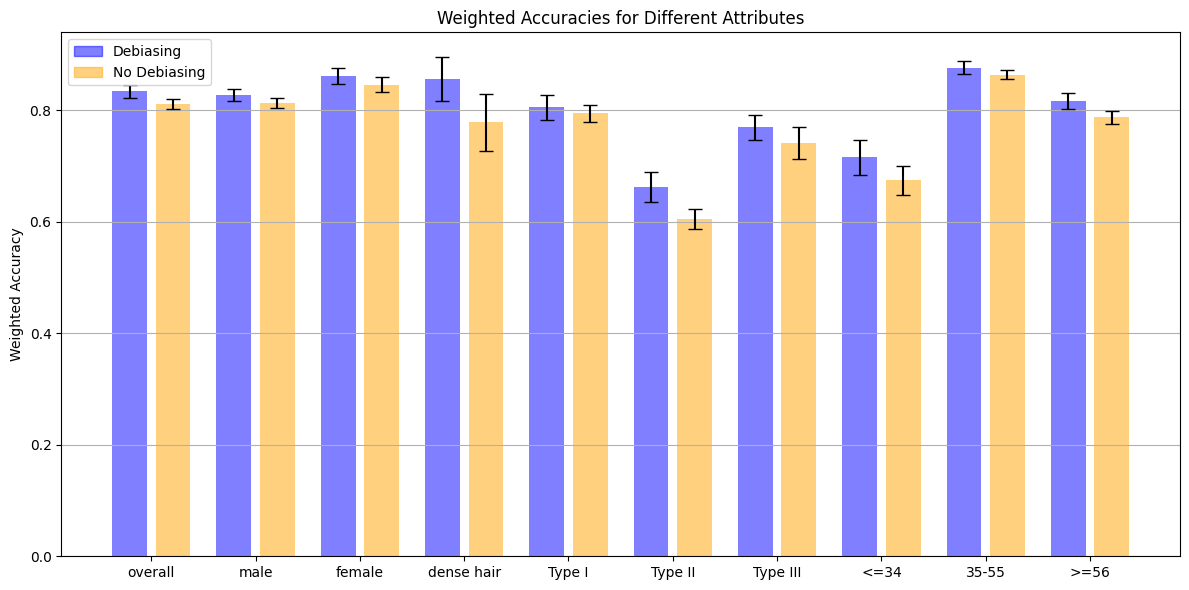

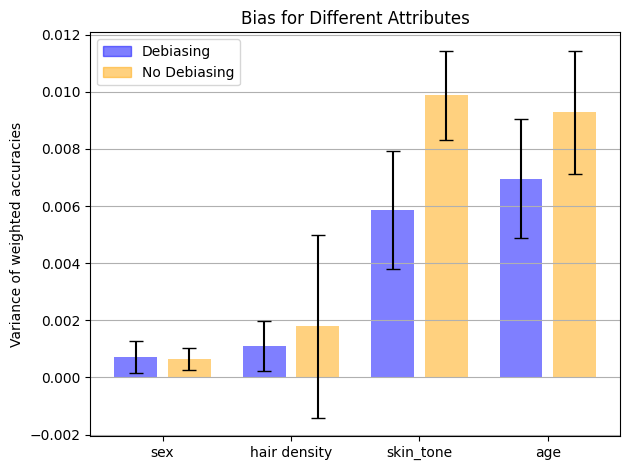

In [43]:
bar_chart_accuracies(transfer_results, transfer_binary, transfer_binary_debias, "transfer_binary_accuracies")
bar_chart_biases(transfer_results, transfer_binary, transfer_binary_debias, "transfer_binary_biases")

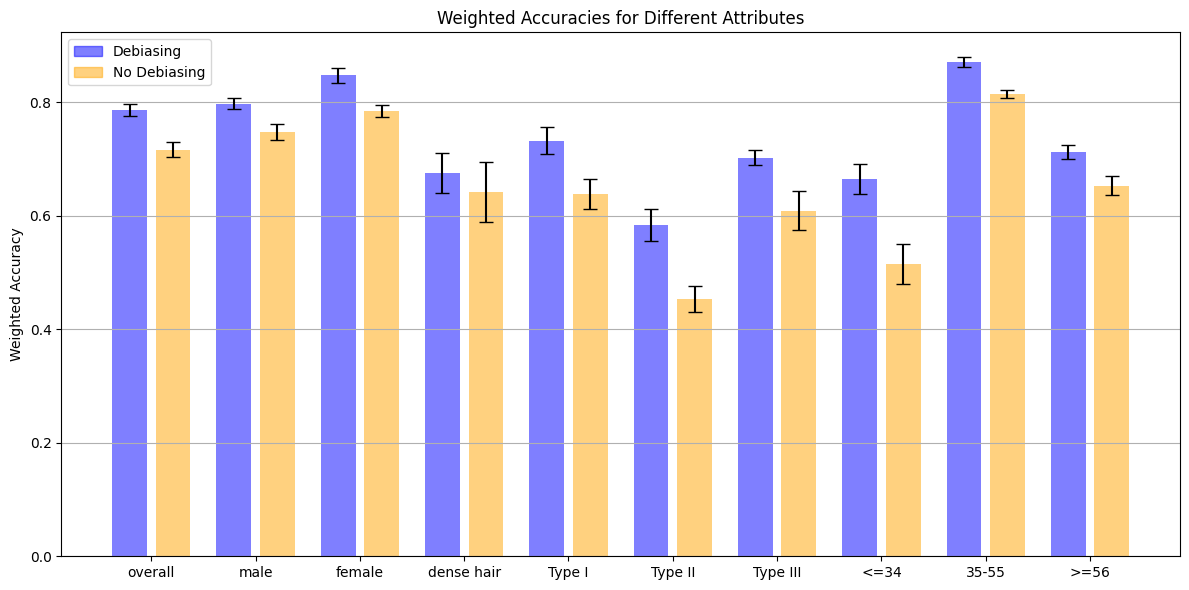

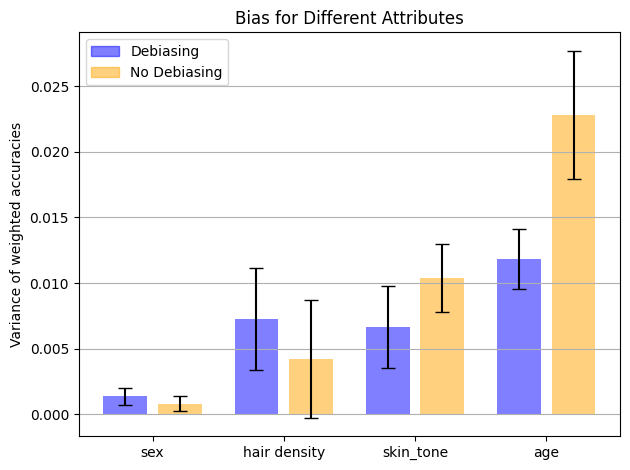

In [44]:
bar_chart_accuracies(simple_binary_results, simple_binary, simple_binary_debias, "simple_binary_accuracies")
bar_chart_biases(simple_binary_results, simple_binary, simple_binary_debias, "simple_binary_biases")

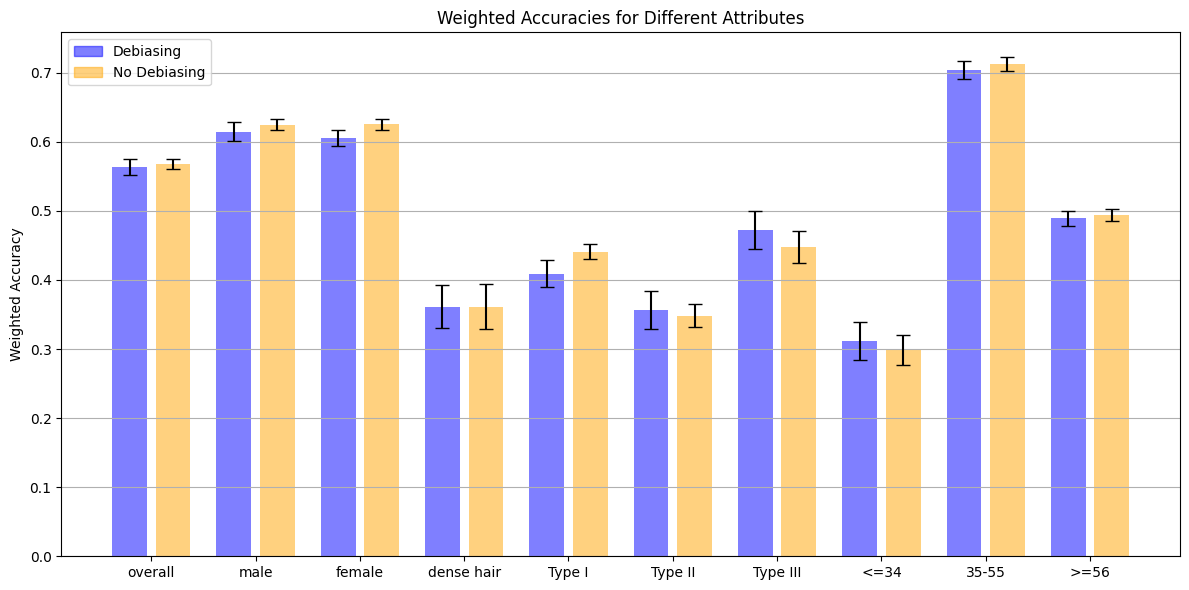

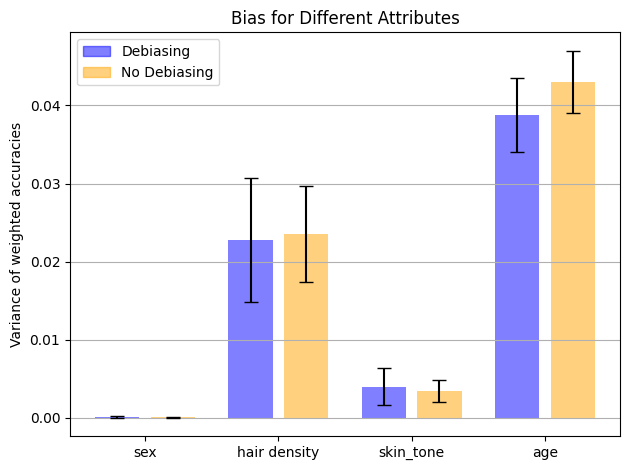

In [45]:
bar_chart_accuracies(multi_results, multi, multi_debias, "multi_accuracies")
bar_chart_biases(multi_results, multi, multi_debias, "multi_biases")

0.7326007485389708
0.6380952596664428
0.5842443823814393
0.45337620675563817
0.702272719144821
0.6090909004211427


In [ ]:
%autoreload 2

from scipy.stats import ttest_ind, mannwhitneyu
import numpy as np


skin_bias = 0.0
biases_deb = []
for run in debiasing_runs:
    bias = results[run]["skin_tone_bias"]
    biases_deb.append(bias)
    skin_bias += bias*0.1
print(skin_bias)
biases_nodeb = []
skin_bias = 0.0
for run in no_debiasing_runs:
    bias = results[run]["skin_tone_bias"]
    biases_nodeb.append(bias)
    skin_bias += bias*0.1
print(skin_bias)
print(biases_deb)
print(biases_nodeb)

t_statistic, p_value = ttest_ind(biases_deb, biases_nodeb)

alpha = 0.05
print(p_value)
if p_value < alpha:
    print("The means of the two groups are significantly different.")
else:
    print("There is no significant difference between the means of the two groups.")

    
statistic, p_value = mannwhitneyu(biases_deb, biases_nodeb)

# Display the test results
print("Mann-Whitney U statistic:", statistic)
print("p-value:", p_value)

alpha = 0.05
if p_value < alpha:
    print("Null hypothesis rejected. There is a significant difference between the groups.")
else:
    print("Null hypothesis accepted. There is no significant difference between the groups.")


0.0066573064114000624
0.010400229569693518
[0.008572261468672812, 0.013921042192858835, 0.002265740723128573, 0.006771572318047703, 0.003609847369975938, 0.0062098597357014285, 0.0058191138587453395, 0.008796776507846715, 0.006442551441477207, 0.004164298497546071]
[0.009513646021319508, 0.009503417530049537, 0.014254921867285239, 0.008111119997154267, 0.0075354540696913235, 0.011733803998745648, 0.006216439125500924, 0.013333886421762328, 0.010401757806592768, 0.013397848858833624]
0.012440576638659056
The means of the two groups are significantly different.
Mann-Whitney U statistic: 17.0
p-value: 0.014019277113959953
Null hypothesis rejected. There is a significant difference between the groups.


In [ ]:
import matplotlib.pyplot as plt

values = biases_nodeb
# Creating a single column for x-axis
x = np.concatenate((np.zeros(len(values)), np.ones(len(values))))

values = biases_deb + biases_nodeb
print(len(values))
print(len(x))
# Plotting the values as scatter plot
plt.scatter(x, values)

# Adding labels and title
plt.xlabel('Column')
plt.ylabel('Value')
plt.title('Scatter Plot of Values')

# Displaying the plot
plt.show()

In [ ]:
import torch
metric = torchmetrics.classification.MulticlassAccuracy(num_classes=2, average="weighted")
result = metric(torch.tensor([0, 1, 0, 0,1,1,0,1]), torch.tensor([0, 0,0,1,1,1, 1, 1]))
print(result)
metric = torchmetrics.classification.MulticlassAccuracy(num_classes=2)
result = metric(torch.tensor([0, 1, 0, 0,1,1,0,1]), torch.tensor([0, 0,0,1,1,1, 1, 1]))
print(result)

In [ ]:

values = [0.7292723059654236,
0.7094131469726563,
0.6589035153388978,
0.6190443456172943,
0.7314824819564819,
0.6652830243110658,
0.6958333253860474,
0.7211309552192688]

x_indices = range(len(values))

plt.bar(x_indices, values)

plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Bar Chart')
plt.xticks(x_indices)
plt.tight_layout()

plt.show()